# Title: Bank Customer Churn Prediction

## Objective:
##### Our objective is to build a machine learning model to predict whether the customer will churn or not in the next six months.

##### Data Source: Kaggle dataset

#### About dataset: 
The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

Variable

ID: Unique Identifier of a row

Age: Age of the customer

Gender: Gender of the customer (Male and Female)

Income: Yearly income of the customer

Balance: Average quarterly balance of the customer

Vintage: No. of years the customer is associated with bank

Transaction_Status: Whether the customer has done any transaction in the past 3 months or not

Product_Holdings: No. of product holdings with the bank

Credit_Card: Whether the customer has a credit card or not

Credit_Category: Category of a customer based on the credit score

Is_Churn: Whether the customer will churn in next 6 months or not

The goal of the dataset is to predict which customers are likely to churn, based on the input features provided. By predicting customer churn, banks can take appropriate measures to retain their customers and reduce customer turnover.

### Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import re
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, precision_score, recall_score, make_scorer
from sklearn.metrics import classification_report,confusion_matrix

### Import Data

In [2]:
# Training data
train=pd.read_csv('train_churn.csv')
train.head()

ID  Age  Gender         Income     Balance  Vintage  \
0  84e2fcc9   36  Female       5L - 10L   563266.44        4   
1  57fea15e   53  Female   Less than 5L   875572.11        2   
2  8df34ef3   35  Female  More than 15L   701607.06        2   
3  c5c0788b   43  Female  More than 15L  1393922.16        0   
4  951d69c4   39  Female  More than 15L   893146.23        1   

   Transaction_Status Product_Holdings  Credit_Card Credit_Category  Is_Churn  
0                   0                1            0         Average         1  
1                   1                1            1            Poor         0  
2                   1                2            0            Poor         0  
3                   1                2            1            Poor         1  
4                   1                1            1            Good         1

In [3]:
# Testing data
test=pd.read_csv('test_churn.csv')
test.head()

ID  Age  Gender         Income     Balance  Vintage  \
0  55480787   50  Female  More than 15L  1008636.39        2   
1  9aededf2   36    Male       5L - 10L   341460.72        2   
2  a5034a09   25  Female      10L - 15L   439460.10        0   
3  b3256702   41    Male   Less than 5L    28581.93        0   
4  dc28adb5   48    Male  More than 15L  1104540.03        2   

   Transaction_Status Product_Holdings  Credit_Card Credit_Category  
0                   1                2            1         Average  
1                   0                2            1         Average  
2                   0                2            1            Good  
3                   1                2            1            Poor  
4                   1               3+            0            Good

In [4]:
train.shape,test.shape

((6650, 11), (2851, 10))

In [5]:
## Cheaking total row, total column, null-value, Dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


#### Solution approach
1. There are continuous variable as well as categorical variables.
2. categorical variables need to be chnaged into numerical discrete values.
3. Continuous variables need to be checked for their distribution type.
4. All the variables need to be standardized to make them fall in same range
5. Then the classification algorithms is used

In [6]:
train.describe()

Age       Balance      Vintage  Transaction_Status  \
count  6650.000000  6.650000e+03  6650.000000         6650.000000   
mean     41.130226  8.045954e+05     2.250226            0.515789   
std       9.685747  5.157549e+05     1.458795            0.499788   
min      21.000000  6.300000e+01     0.000000            0.000000   
25%      34.000000  3.922642e+05     1.000000            0.000000   
50%      40.000000  7.649386e+05     2.000000            1.000000   
75%      47.000000  1.147124e+06     3.000000            1.000000   
max      72.000000  2.436616e+06     5.000000            1.000000   

       Credit_Card     Is_Churn  
count  6650.000000  6650.000000  
mean      0.664361     0.231128  
std       0.472249     0.421586  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     0.000000  
75%       1.000000     0.000000  
max       1.000000     1.000000

In [7]:
## Cheaking wheather any duplicate record present or not
train['ID'].duplicated().sum()

0

In [8]:
train['Gender'].value_counts()

Gender
Male      3612
Female    3038
Name: count, dtype: int64

In [9]:
train['Income'].value_counts()

Income
10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: count, dtype: int64

In [10]:
train['Vintage'].value_counts()

Vintage
3    1405
1    1354
2    1328
4    1296
0     956
5     311
Name: count, dtype: int64

In [11]:
train['Transaction_Status'].value_counts()

Transaction_Status
1    3430
0    3220
Name: count, dtype: int64

In [12]:
train['Product_Holdings'].value_counts()

Product_Holdings
1     3200
2     3182
3+     268
Name: count, dtype: int64

In [13]:
train['Credit_Card'].value_counts()

Credit_Card
1    4418
0    2232
Name: count, dtype: int64

In [14]:
train['Credit_Category'].value_counts()

Credit_Category
Poor       3076
Average    2043
Good       1531
Name: count, dtype: int64

In [15]:
train['Is_Churn'].value_counts()

Is_Churn
0    5113
1    1537
Name: count, dtype: int64

Clearly the data is imbalanced

### Data Visualization

<AxesSubplot:xlabel='Balance', ylabel='Count'>

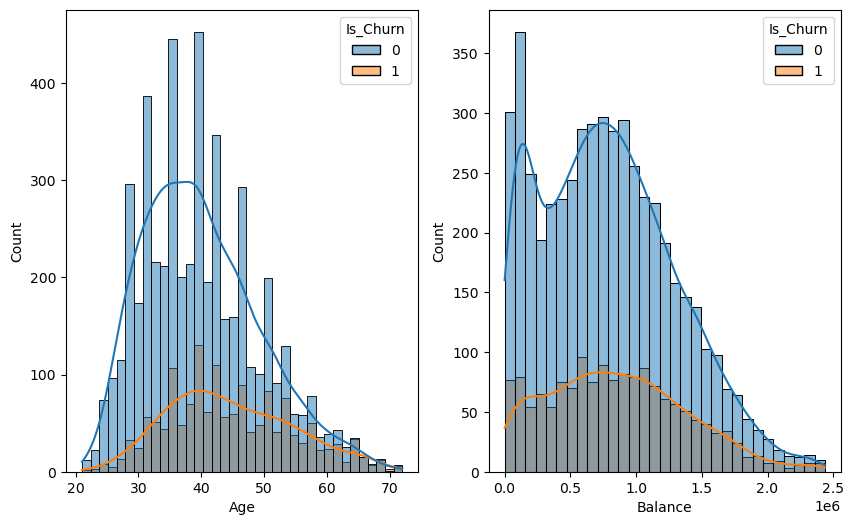

In [16]:
# let check the distribution of the continuous variable 'age' and 'Balance'
plt.figure(figsize= (10,6))
plt.subplot(1,2,1)
sns.histplot(data=train, x = 'Age', hue='Is_Churn', kde=True)
plt.subplot(1,2,2)
sns.histplot(data=train, x = 'Balance', hue='Is_Churn', kde=True)

##### observation:Both features follows right or positively skewed distribution

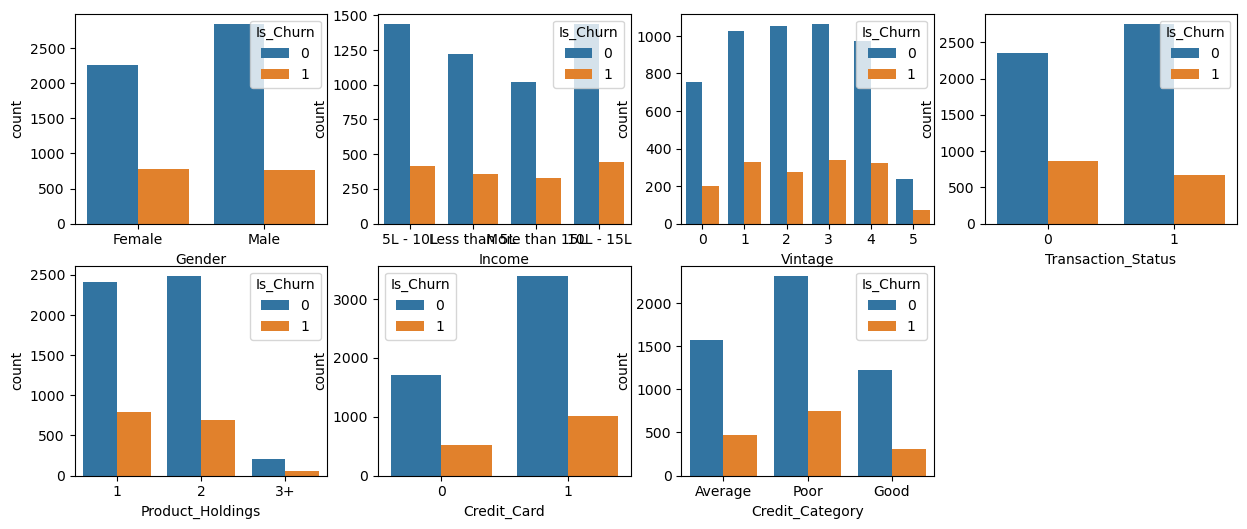

In [17]:
# lets check the counts of each categorical variable. 
list = ['Gender','Income','Vintage','Transaction_Status','Product_Holdings','Credit_Card','Credit_Category']
plt.figure(figsize=(15,6))
for i,x in enumerate(list):
    plt.subplot(2,4,i+1)
    sns.countplot(data= train, x=train[x], hue='Is_Churn')

##### Observation:
    1.Greater percentage of females are likely to churn
    2.Higher Income customers with earnings greater than 10 Lakhs are more likely to churn
    3.Almost equal number of customers have 1 to 2 products holdings. It's rare for a customer to have 3 or more product holdings. Also, there is no such distinction in churn rate based on number of product holdings.
    4.Customers who has not done any transaction in the past 3 months are more likely to churn
    5. Customers with credit card are more in number and are more likely to churn
    6.Customers with poor credit ratings dominate the dataset and are also more likely to exit

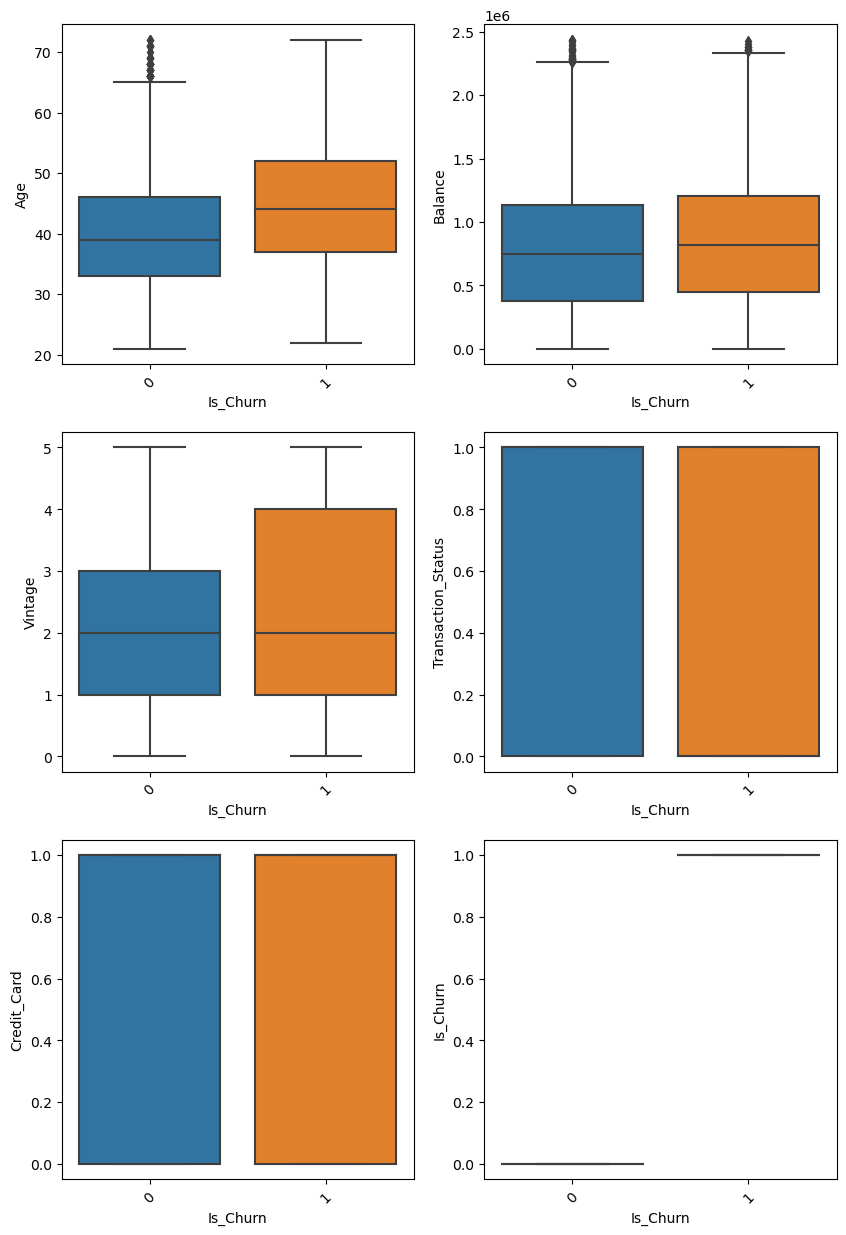

In [18]:
numerical_features =train.select_dtypes(include=['int64','float64']).columns.tolist()
# Plots between Target Categorical and Numerical Variable
fig = plt.figure(figsize=(10,15))
for index,var in enumerate(numerical_features):
    plt.subplot(3,2,index+1) 
    plt.xticks(rotation=45)
    sns.boxplot(x="Is_Churn",y = var, data=train)
    plt.plot()

##### Observation:
    We see a couple of outliers in the Age feature whereas there are a few in Balance feature

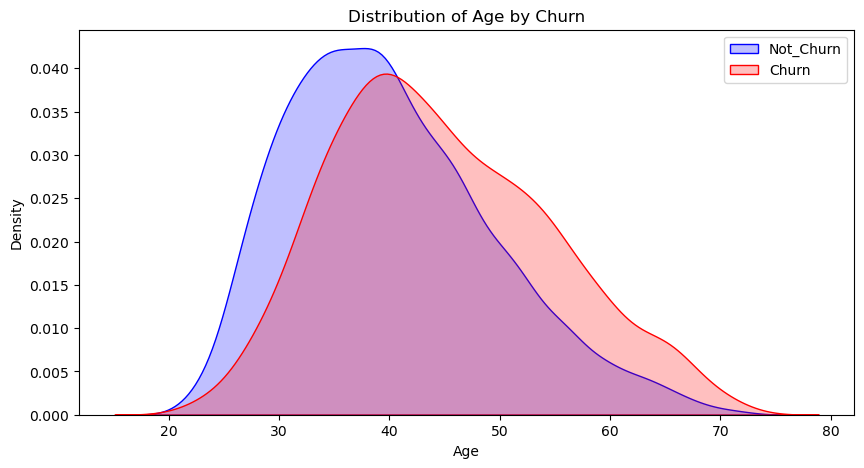

In [19]:
# Variation of churn rate with age of customers

plt.figure(figsize=(10,5))
ax = sns.kdeplot(train['Age'][(train['Is_Churn'] == 0)], color = 'Blue', fill=True)
ax = sns.kdeplot(train['Age'][(train['Is_Churn'] == 1)], color = 'Red', fill=True)

ax.legend(['Not_Churn', 'Churn'], loc = 'upper right')
ax.set_ylabel("Density")
ax.set_xlabel('Age')
ax.set_title('Distribution of Age by Churn')
plt.show()

##### Observation:
    The above plot shows that elder people are more likely to churn. The blue region (Not_Churned) is centered around 35 and is slightly right skewed whereas the red region (Churned) is centered around 40 and right skewed.

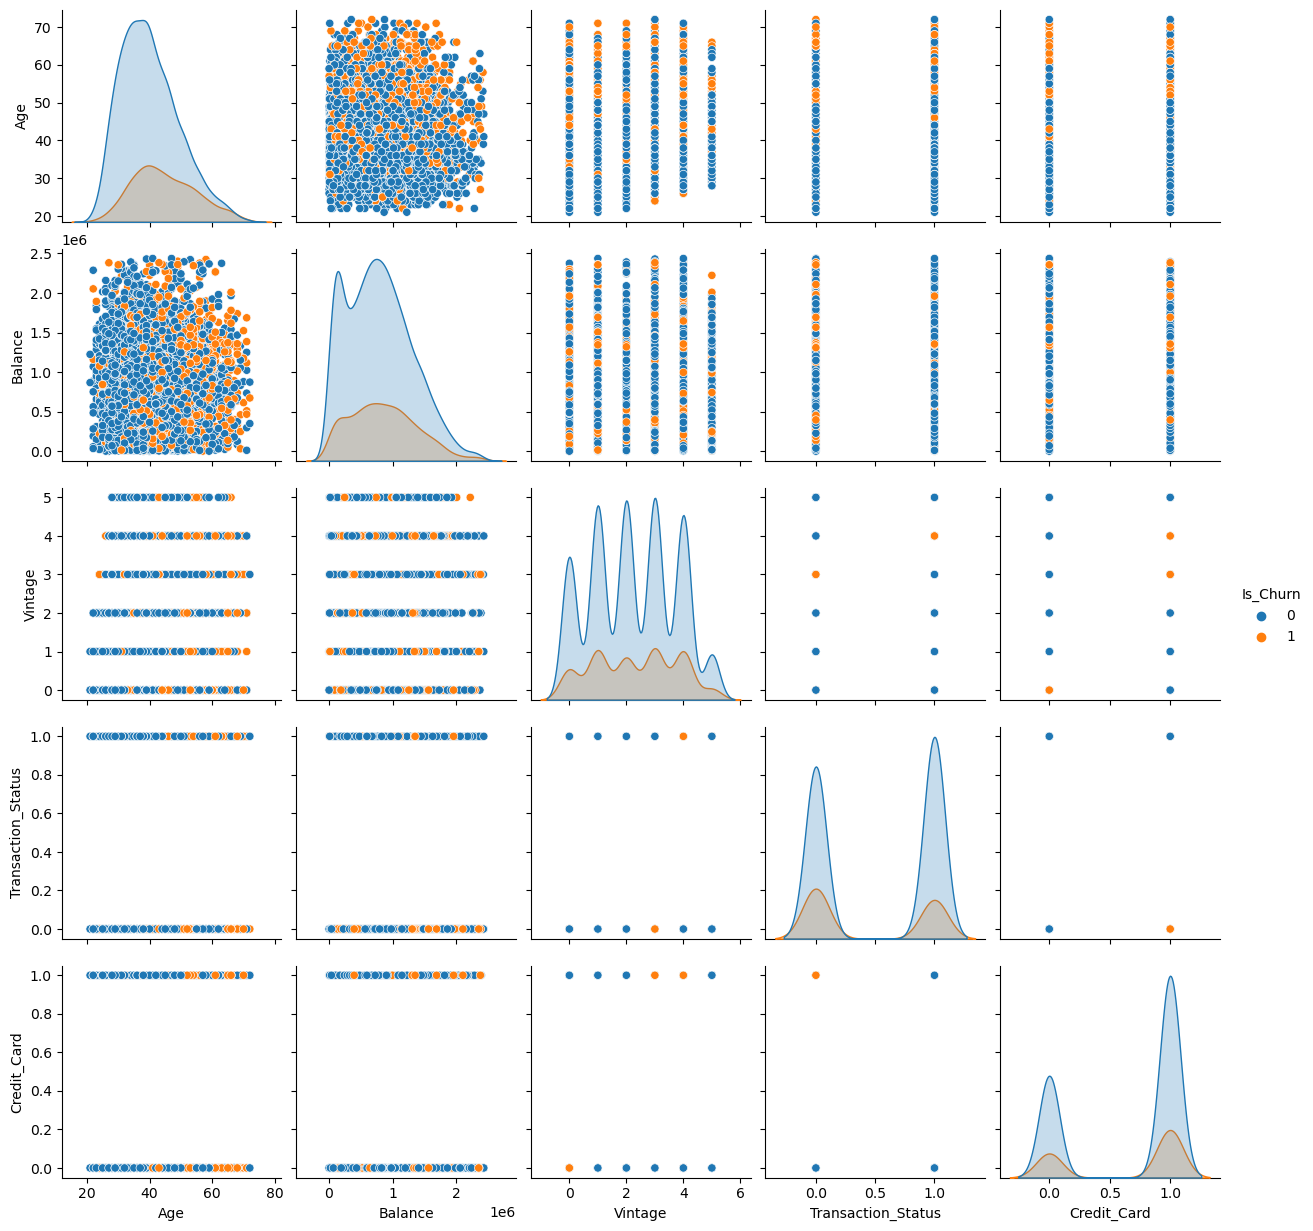

In [20]:
#Variation of each feature with respect to other features
sns.pairplot(train, hue='Is_Churn')
plt.show()

##### Observation:
    The above pairplot shows that no two feature has linear relation. It also confirms our earlier findings that elderly people are more likely to churn and new customers who have been served for less than 2 years are more likely to churn. Long term customers seem to be happy with the service and are less likely to leave.

In [21]:
# Percent of churned vs not-churned customers

labels = ['Churned', 'Retained']
values = [train.Is_Churn[train['Is_Churn']==1].count(), train.Is_Churn[train['Is_Churn']==0].count()]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1], title='Proportion of customer churned and retained')])
fig.show()

##### Observation:
    We have imbalance in our target attribute.

### Data Preprocessing

We have a good understanding of the data from the previous section. Here, we will make some changes to the dataset to make it model ready. We are going to perform the following operations:

1.Handle Missing Values

2.Handle Outliers

3.Encode Categorical Features

4.Feature Scaling

5.Handling Imbalanced Class


##### 1. Missing Values

In [22]:
train.isna().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [23]:
test.isna().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
dtype: int64

###### So both the dataset don't have any missing value

#### 2. Handling Outliers
In the EDA section we identified that Age and Balance features do have a couple of outliers and since, all are beyond the upper limit we will consider the upper range only to detect the outliers in this scenario.

In [24]:
def upper_bound(df, feat):
    ''' Calculate IQR and the respective upper and lower bounds '''
    upper= lower = per25 = per75 = iqr = 0
    per25 = np.percentile(df[feat], 25)
    per75 = np.percentile(df[feat], 75)
    iqr = per75 - per25
    #lower = per25 - (1.5*iqr)
    upper = per75 + (1.5*iqr)
    return upper

In [25]:
# Count of outliers for each feature in train as well as test set

print("Train: In Age", train[train['Age']>upper_bound(train, 'Age')].shape[0], ' In Balance: ', train[train['Balance']>upper_bound(train, 'Balance')].shape[0])
print("Test: In Age", test[test['Age']>upper_bound(test, 'Age')].shape[0], ' In Balance: ', test[test['Balance']>upper_bound(test, 'Balance')].shape[0])

Train: In Age 57  In Balance:  38
Test: In Age 25  In Balance:  18


In [26]:
# Replacing the outliers with the upper limit values

train['Age'] = train['Age'].apply(lambda x: round(upper_bound(train, 'Age')) if (x > upper_bound(train, 'Age')) else x)
test['Age'] = test['Age'].apply(lambda x: round(upper_bound(test, 'Age')) if (x > upper_bound(test, 'Age')) else x)

train['Balance'] = train['Balance'].apply(lambda x: round(upper_bound(train, 'Balance')) if (x > upper_bound(train, 'Balance')) else x)
test['Balance'] = test['Balance'].apply(lambda x: round(upper_bound(test, 'Balance')) if (x > upper_bound(test, 'Balance')) else x)

We see that there are 57 and 25 outliers in Age feature and 38 and 18 in Balance feature in train and test set respectively. Replacing these values with the upper bound value will be advantageous while Binning these features in the later section.

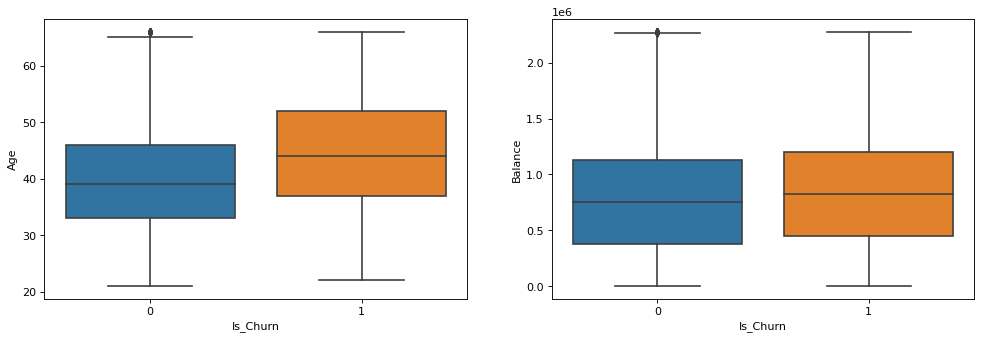

In [27]:
# Verifying if any outliers exist:
plt.figure(figsize=(15, 10), dpi=80)

plt.subplot(221)
sns.boxplot(train,x="Is_Churn",y = 'Age')

plt.subplot(222)
sns.boxplot(train,x="Is_Churn",y = 'Balance')
plt.show()

#### 3. Encoding
     Model understands only numerical values, so we have to assign numerical values to each categorical values.

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var = ['Product_Holdings','Income','Gender','Credit_Category']
for i in var:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

In [29]:
train.head()

ID  Age  Gender  Income     Balance  Vintage  Transaction_Status  \
0  84e2fcc9   36       0       1   563266.44        4                   0   
1  57fea15e   53       0       2   875572.11        2                   1   
2  8df34ef3   35       0       3   701607.06        2                   1   
3  c5c0788b   43       0       3  1393922.16        0                   1   
4  951d69c4   39       0       3   893146.23        1                   1   

   Product_Holdings  Credit_Card  Credit_Category  Is_Churn  
0                 0            0                0         1  
1                 0            1                2         0  
2                 1            0                2         0  
3                 1            1                2         1  
4                 0            1                1         1

In [30]:
train.dtypes

ID                     object
Age                     int64
Gender                  int32
Income                  int32
Balance               float64
Vintage                 int64
Transaction_Status      int64
Product_Holdings        int32
Credit_Card             int64
Credit_Category         int32
Is_Churn                int64
dtype: object

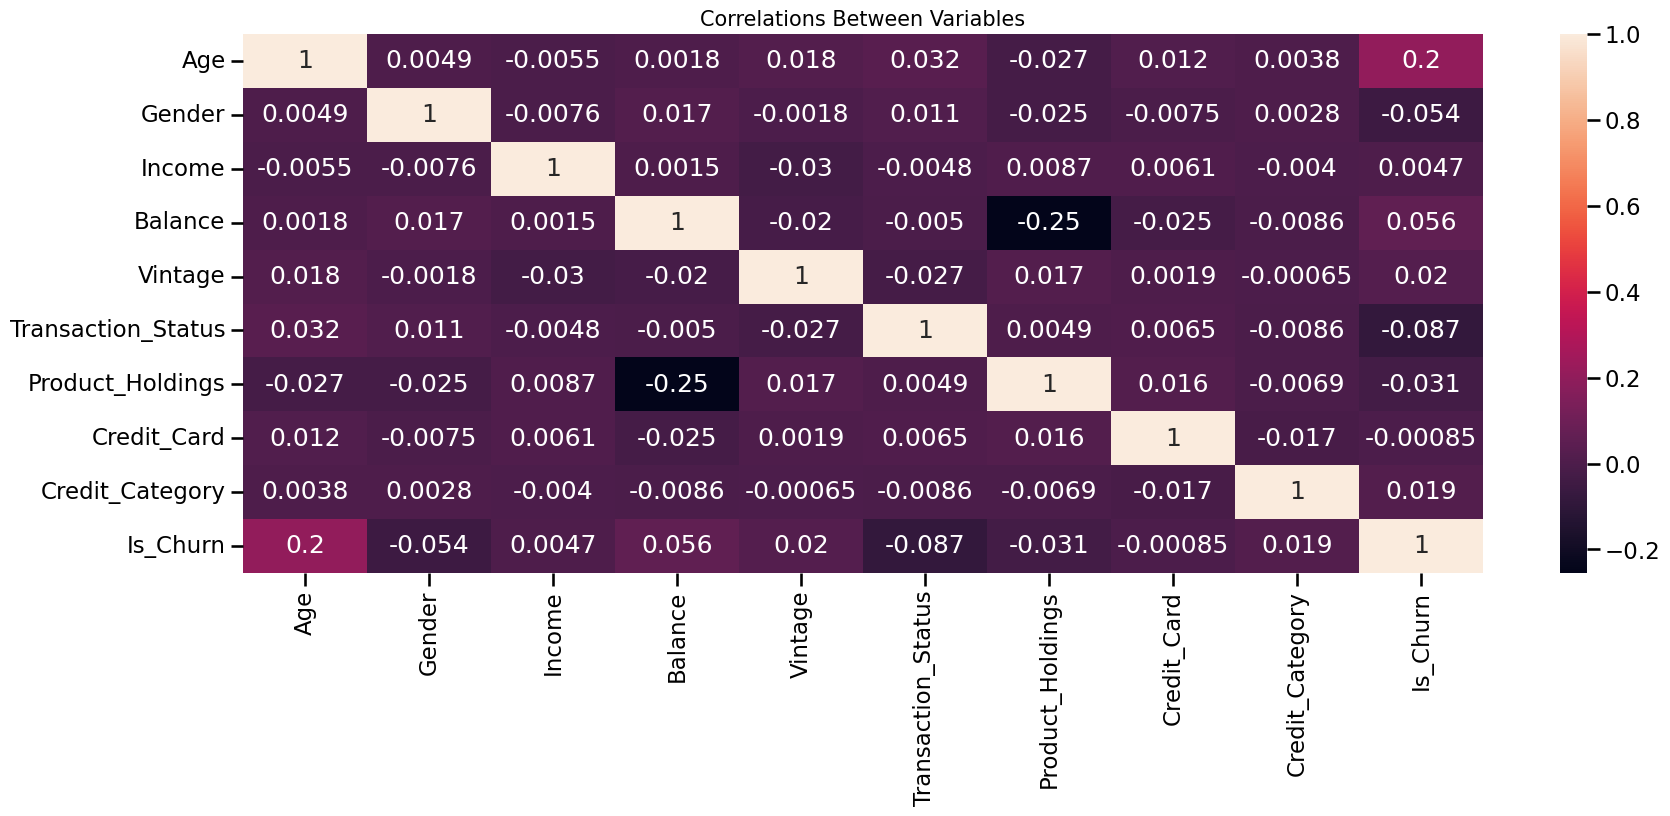

In [109]:
## visulation for correlation beetween variables
plt.figure(figsize=(20,7))
sns.heatmap(train.drop('ID',axis=1).corr(),annot=True)
plt.title("Correlations Between Variables",size=15)
plt.show()

##### Observation:
    whether a customer leaves or not is strongly Correlated with Customer's Age followed by his transaction status and account balance

#### 4.Scaling
    Scaling is an important part of Feature Engineering. The idea behind scaling is to bring down all the values in a feature within a certain range. Here, we have used StandardScaler on Age, Balance, Vintage features to bring down the mean to 0 and the varience to 1 of these features.

In [31]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [32]:
num_features = ['Age', 'Balance','Vintage']
train[num_features] = sc.fit_transform(train[num_features])
test[num_features] = sc.fit_transform(test[num_features])


In [33]:
train.head()

ID       Age  Gender  Income   Balance   Vintage  Transaction_Status  \
0  84e2fcc9 -0.530860       0       1 -0.468255  1.199556                   0   
1  57fea15e  1.236432       0       2  0.138740 -0.171542                   1   
2  8df34ef3 -0.634818       0       3 -0.199377 -0.171542                   1   
3  c5c0788b  0.196849       0       3  1.146201 -1.542639                   1   
4  951d69c4 -0.218985       0       3  0.172897 -0.857091                   1   

   Product_Holdings  Credit_Card  Credit_Category  Is_Churn  
0                 0            0                0         1  
1                 0            1                2         0  
2                 1            0                2         0  
3                 1            1                2         1  
4                 0            1                1         1

#### 5.Handling Imbalanced Class
    Since our target attribute is highly imbalanced, we will use RandomOverSampling technique to balance the imbalance.

In [34]:
# Define Target Variable (y) and Input Variables (X)
X=train.drop(['Is_Churn','ID'], axis=1)
y=train['Is_Churn']

In [35]:
X.shape,y.shape

((6650, 9), (6650,))

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=2529)

In [37]:
X_ros,y_ros=ros.fit_resample(X,y)

In [38]:
X_ros.shape,y_ros.shape,X.shape,y.shape

((10226, 9), (10226,), (6650, 9), (6650,))

In [39]:
y_ros.value_counts()

Is_Churn
1    5113
0    5113
Name: count, dtype: int64

<AxesSubplot:ylabel='Frequency'>

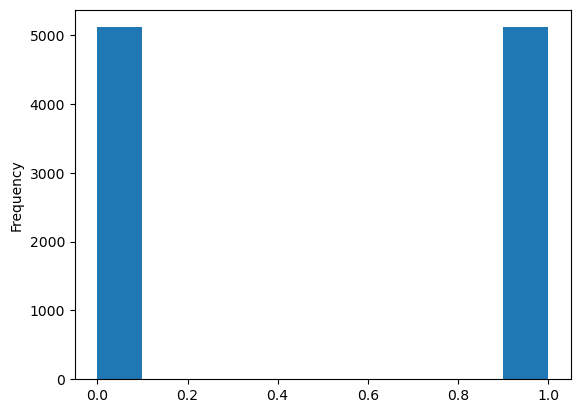

In [40]:
y_ros.plot(kind='hist')

### Train_Test_Split

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# Split random over sample data
X_ros_train,X_ros_test,y_ros_train,y_ros_test=train_test_split(X_ros,y_ros,test_size=0.3,random_state=2529)

### Model Building and Evaluation

In [43]:
def pipeline(learner_list,train_x,train_y,test_x,test_y): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: outcome training set
       - X_test: features testing set
       - y_test: outcome testing set
    '''
    
    # Get length of Training Data:
    size = len(train_y)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(train_x,train_y)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(test_x)
        predictions_train = learner.predict(train_x)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(test_y, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(train_y, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

In [44]:
models = [ XGBClassifier(),
           RandomForestClassifier(),
          SVC(max_iter=10000), AdaBoostClassifier(),
         LogisticRegression(), SGDClassifier()]

In [45]:
from time import time
re = pipeline(models, X_ros_train, y_ros_train, X_ros_test,y_ros_test)
result = pd.DataFrame(re)
result = result.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Prediction Time','Accuracy: Train', 'Training Time'])

Training XGBClassifier
Training XGBClassifier finished in 0.68 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 1.09 sec
----------------------------------------------------
Training SVC
Training SVC finished in 4.26 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 0.55 sec
----------------------------------------------------
Training LogisticRegression
Training LogisticRegression finished in 0.05 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.05 sec
----------------------------------------------------


In [46]:
result.sort_values(by = 'Accuracy: Test', inplace = True, ascending = False)
result.reset_index(drop = True)

Algorithm  Accuracy: Test  Prediction Time  Accuracy: Train  \
0  RandomForestClassifier        0.887549         0.304648         1.000000   
1           XGBClassifier        0.785202         0.025000         0.930008   
2                     SVC        0.635593        15.450867         0.653674   
3      AdaBoostClassifier        0.619296         0.177999         0.617770   
4      LogisticRegression        0.615711         0.006946         0.612182   
5           SGDClassifier        0.574967         0.010994         0.575580   

   Training Time  
0       1.092632  
1       0.682189  
2       4.258128  
3       0.551849  
4       0.045049  
5       0.053005

##### Approach:
    1.Based on descending order of test accuracy we are choosing top 3 models.
    2.Performing paramerer tuning using GridSearchCV we are going to find most suitable paramerer combination.
    3.Then we will compare these 3 models performance based on classification report and AUC Score.

In [47]:
# We are going to create a function to print classification report and confusion matrix for each model
def model_score(model):
    y_pred = model.predict(X_ros_test)
    print(classification_report(y_ros_test, y_pred,digits=4))
    cm = confusion_matrix(y_ros_test, y_pred)
    sns.set_context('talk')
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [48]:
# Available parameter keys of RandomForest
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [49]:
from sklearn.model_selection import GridSearchCV
# RandomForestClassifier parameter tuning 
param_grid = {
    'bootstrap': [True],
    'max_depth': [13,20,30],
    'max_features': [3,5,8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5,8],
    'n_estimators': [200,300, 400,500]
}
#Create a based model
rf = RandomForestClassifier()
#Instantiate the grid search model
gs1 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2, error_score='raise')

In [50]:
# Fit the grid search to the data
gs1.fit(X_ros_train,y_ros_train)

Fitting 2 folds for each of 216 candidates, totalling 432 fits


GridSearchCV(cv=2, error_score='raise', estimator=RandomForestClassifier(),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [13, 20, 30],
                         'max_features': [3, 5, 8],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [5, 8],
                         'n_estimators': [200, 300, 400, 500]},
             verbose=2)

In [51]:
print(gs1.best_estimator_)

RandomForestClassifier(max_depth=20, max_features=8, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=500)


In [52]:
print('Best score:', gs1.best_score_)

Best score: 0.7341436155350657


In [53]:
rf=RandomForestClassifier(max_depth=20, max_features=5, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=500)

In [54]:
rf.fit(X_ros_train,y_ros_train)

RandomForestClassifier(max_depth=20, max_features=5, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=500)

In [55]:
rf_pred=rf.predict(X_ros_test)

              precision    recall  f1-score   support

           0     0.8851    0.7738    0.8257      1543
           1     0.7970    0.8984    0.8446      1525

    accuracy                         0.8357      3068
   macro avg     0.8410    0.8361    0.8352      3068
weighted avg     0.8413    0.8357    0.8351      3068



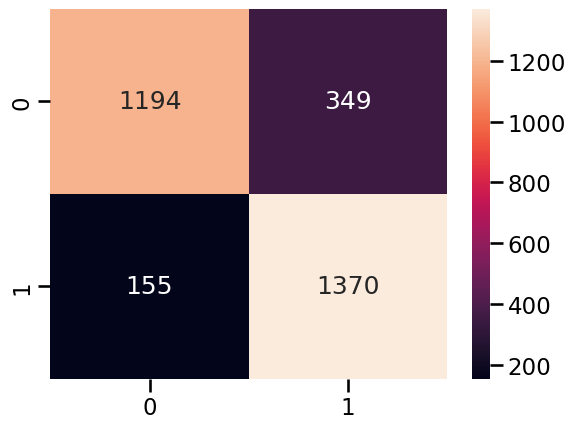

In [56]:
# classification report and confution matrix for RandomForestClassifier model
model_score(rf)

In [57]:
# Available parameter keys of XGBClassifier
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [58]:
# XGBClassifier parameter tuning
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 0.9]
}
#Instantiate the grid search model
gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=2, scoring='roc_auc',error_score='raise')
gs2.fit(X_ros_train, y_ros_train)



GridSearchCV(cv=2, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
  

In [59]:
print('Best score:', gs2.best_score_)


Best score: 0.8107223268348589


In [60]:
print(gs2.best_params_)

{'base_score': 0.9, 'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0.5}


In [61]:
xgb=XGBClassifier(base_score= 0.9, booster= 'gbtree', gamma= 0, learning_rate= 0.1, n_estimators= 500, reg_alpha= 0, reg_lambda= 0.5)

In [62]:
xgb.fit(X_ros_train, y_ros_train)

XGBClassifier(base_score=0.9, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [63]:
xgb_pred=xgb.predict(X_ros_test)

              precision    recall  f1-score   support

           0     0.8840    0.7557    0.8148      1543
           1     0.7844    0.8997    0.8381      1525

    accuracy                         0.8272      3068
   macro avg     0.8342    0.8277    0.8265      3068
weighted avg     0.8345    0.8272    0.8264      3068



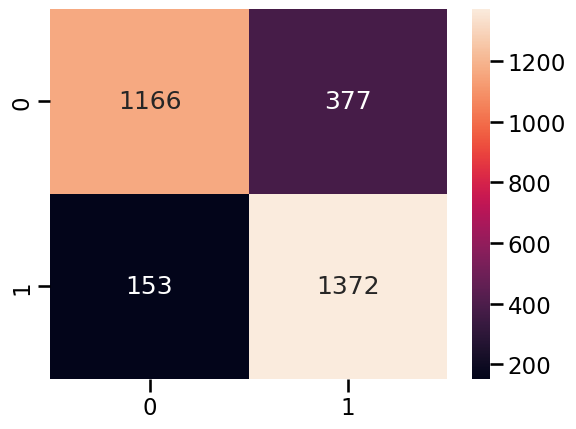

In [64]:
model_score(xgb)

In [65]:
# Available parameter keys of SVM 
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [66]:
# SVM classifier parameter tuning
param_grid={'C':[0.1,1,10],
           'gamma':[1,0.1,0.01],
           'kernel':['rbf'],
           'class_weight':['balanced']}
gs3=GridSearchCV(SVC(),param_grid,refit=True,verbose=2,cv=2)
gs3.fit(X_ros_train,y_ros_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.4s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.4s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.9s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.9s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   3.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   3.1s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.3s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.1s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.8s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   3.0s
[CV] END .C=1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   2.9s
[CV] END .C=1, class_weight=balanced, gamma=0.0

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
             verbose=2)

In [67]:
print(gs3.best_estimator_)

SVC(C=10, class_weight='balanced', gamma=1)


In [68]:
svc=SVC(C=10, class_weight='balanced', gamma=1, probability=True)

In [69]:
svc.fit(X_ros_train,y_ros_train)

SVC(C=10, class_weight='balanced', gamma=1, probability=True)

In [70]:
svc_pred=svc.predict(X_ros_test)

              precision    recall  f1-score   support

           0     0.9045    0.7181    0.8006      1543
           1     0.7640    0.9233    0.8361      1525

    accuracy                         0.8201      3068
   macro avg     0.8342    0.8207    0.8183      3068
weighted avg     0.8346    0.8201    0.8182      3068



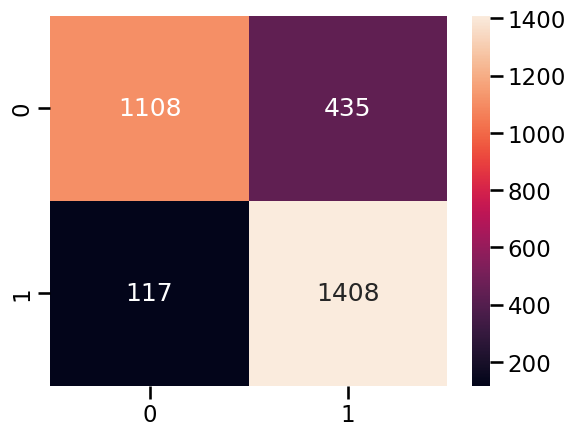

In [71]:
# classification report and confution matrix for SVM model
model_score(svc)

### Model Comparison

In [72]:
# calculating the false positive and true positive rate for each of the models
fpr1, tpr1, thresh1 = roc_curve(y_ros_test, rf.predict_proba(X_ros_test)[:, 1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_ros_test, xgb.predict_proba(X_ros_test)[:, 1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_ros_test, svc.predict_proba(X_ros_test)[:, 1], pos_label=1)

In [73]:
# Fething the Area under the curve 
auc_score1 = roc_auc_score(y_ros_test, rf.predict_proba(X_ros_test)[:, 1])
auc_score2 = roc_auc_score(y_ros_test, xgb.predict_proba(X_ros_test)[:,1])
auc_score3 = roc_auc_score(y_ros_test, svc.predict_proba(X_ros_test)[:, 1])

print("Random Forest(AUC_Score): ", auc_score1)
print("XGBoost(AUC_Score): ", auc_score2)
print("SVC(AUC_Score):", auc_score3)

Random Forest(AUC_Score):  0.9170787161480188
XGBoost(AUC_Score):  0.904553828501004
SVC(AUC_Score): 0.8973715244945445


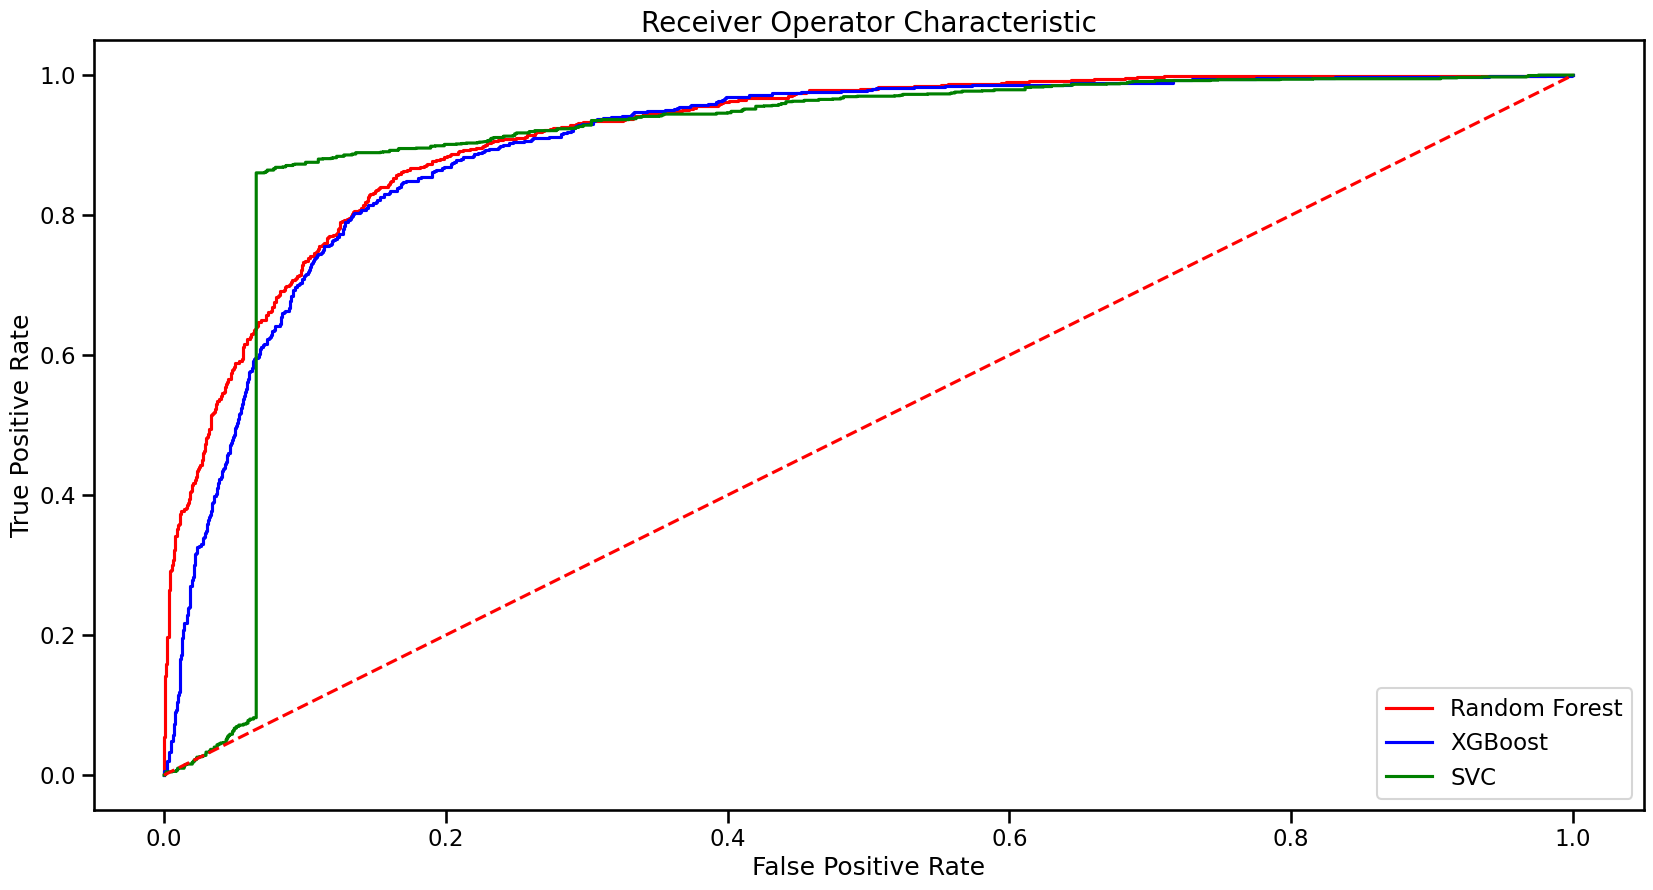

In [74]:
# Plotting ROC curve
plt.figure(figsize=(20,10))
plt.plot(fpr1, tpr1,  color = 'red', label='Random Forest')
plt.plot(fpr2, tpr2, color = 'blue', label='XGBoost')
plt.plot(fpr3, tpr3, color = 'green', label='SVC')
         
plt.title('Receiver Operator Characteristic', fontsize=20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1],'r--') 
plt.legend(loc = 'best')
plt.show()

### Model Comparison Results:

    ROC-AUC curve shows the model performance by plotting the false positive rate to true positive rate
    More the skewness of the curve towards the upper left corner higher is the area under the roc curve and better is the model performance.
    From the ROC-AUC curve it is clear that all three model performances are very close.
    Random Forest showed a tremendous performance but it is likely to overfit.

    Both Random Forest(Bagging) and XGBoost(Boosting) are ensemble techniques and their performances are very close.
    All of the models have achived above 80% accuracy and above 0.80 f1-score and around 0.90 AUC_Score.

###### RandomForestClassifier has got highest score in every aspect. So,we are choosing Randomforest as our final model for prediction purpose

### Prediction

In [75]:
test_new=test.drop('ID',axis=1)

In [76]:
test_new.head()

Age  Gender  Income   Balance   Vintage  Transaction_Status  \
0  0.918856       0       3  0.380308 -0.148337                   1   
1 -0.547566       1       1 -0.893472 -0.148337                   0   
2 -1.699756       0       0 -0.706370 -1.490908                   0   
3 -0.023844       1       2 -1.490824 -1.490908                   1   
4  0.709367       1       3  0.563408 -0.148337                   1   

   Product_Holdings  Credit_Card  Credit_Category  
0                 1            1                0  
1                 1            1                0  
2                 1            1                1  
3                 1            1                2  
4                 2            0                1

In [77]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 2851 non-null   float64
 1   Gender              2851 non-null   int32  
 2   Income              2851 non-null   int32  
 3   Balance             2851 non-null   float64
 4   Vintage             2851 non-null   float64
 5   Transaction_Status  2851 non-null   int64  
 6   Product_Holdings    2851 non-null   int32  
 7   Credit_Card         2851 non-null   int64  
 8   Credit_Category     2851 non-null   int32  
dtypes: float64(3), int32(4), int64(2)
memory usage: 156.0 KB


In [79]:
# Predicting Target Dataset
prediction=rf.predict(test_new)

In [80]:
prediction

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [81]:
prediction.shape, test.shape

((2851,), (2851, 10))

In [95]:
ID=test['ID'].values

In [97]:
ID

array(['55480787', '9aededf2', 'a5034a09', ..., 'f708121b', 'f008715d',
       '36b81f59'], dtype=object)

In [96]:
type(ID)

numpy.ndarray

In [90]:
type(prediction)

numpy.ndarray

In [100]:
df=pd.DataFrame({'Customer_ID':ID, 'Is_Churn':prediction})

In [101]:
df

Customer_ID  Is_Churn
0       55480787         0
1       9aededf2         1
2       a5034a09         0
3       b3256702         0
4       dc28adb5         0
...          ...       ...
2846    19e40adf         1
2847    52d5bc8d         0
2848    f708121b         1
2849    f008715d         1
2850    36b81f59         1

[2851 rows x 2 columns]

##### This is our final predicted classification along with customer_ID 

In [102]:
# Saving Target classification dataframe as csv file
df.to_csv('Target_classification.csv')

### Explaination


In this classification problem, a lot of information about the consumers was provided, and the dataset was pretty clean with no missing values and no duplicate values.

With only two classes in the objective feature (0: not churned, 1: churned), it was a binary classification challenge. The classes were imbalanced and the models were predicting all 0s in the target feature. We had employed the over-sampling technique to address this.


we found repeated categorical values in some of the columns, We used LabelEncoder() to assign numerical values for categorical values.Later on, the Age, Balance and Vintage columns were scaled using standardscalar by projecting mean to zero and varience to one.

We created a pipeline to compare testing accauracy of six different models, then we choose top 3 of them, tuned parameters of them compared Classification report and AUC_Score, choosed most suitable model, RandomForestClassifier().

Some key lessons that the Bank can focus to bring down the churn rate--------

1.Greater percentage of females are likely to churn

2.Customers who has not done any transaction in the past 3 months are more likely to churn

3.Customers with credit card are more in number and are more likely to churn

4.Customers with poor credit ratings dominate the dataset and are also more likely to exit

5.High-income customers are difficult to keep as they are more prone to churn


### Scope for Improvement

To improve the model performance and to get higher accuracy the below things can be done:

1.A model's performance increases with increase in data (clean and relevant). If we can increase our training data we can achieve higher accuracy.

2.Experimenting with under-sampling to see whether there is any change in model performance

3.Trying other ensemble techniques like StackingCVClassifier and CatBoost might also help

4.Trying Deep Learning approach, training Artificial Neural Network